In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [5]:

# 1. Load the core datasets from your repository
df_india = pd.read_csv('../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_19_india.csv')
df_vaccine = pd.read_csv('../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_vaccine_statewise.csv')
df_testing = pd.read_csv('../../RAW_DATA/Virus/Covid_19/covid_19_india/StatewiseTestingDetails.csv')

# 2. Standardize Dates
df_india['Date'] = pd.to_datetime(df_india['Date'])
# Vaccine data often uses DD/MM/YYYY
df_vaccine['Date'] = pd.to_datetime(df_vaccine['Updated On'], dayfirst=True)
df_testing['Date'] = pd.to_datetime(df_testing['Date'])

# 3. National Aggregation (Daily Totals for India)
india_daily = df_india.groupby('Date')[['Confirmed', 'Cured', 'Deaths']].sum().reset_index()
vaccine_daily = df_vaccine.groupby('Date')[['Total Individuals Vaccinated']].sum().reset_index()
testing_daily = df_testing.groupby('Date')[['TotalSamples']].sum().reset_index()

# 4. Merge into a Master Dataset
master_df = india_daily.merge(vaccine_daily, on='Date', how='left').merge(testing_daily, on='Date', how='left')

# 5. Fill Missing Data (e.g., days before vaccine rollout)
master_df = master_df.fillna(0)

# 6. Add 'Day' column for time progression
start_date = master_df['Date'].min()
master_df['Day'] = (master_df['Date'] - start_date).dt.days

master_df.to_csv('master_covid_data.csv', index=False)
print("Master dataset created with columns:", master_df.columns.tolist())

Master dataset created with columns: ['Date', 'Confirmed', 'Cured', 'Deaths', 'Total Individuals Vaccinated', 'TotalSamples', 'Day']


In [8]:


# --- USER CONFIGURATION ---
user_fraction = 0.50  # Use 90% of data for training

# Select multiple features to account for external factors
features = ['Day', 'Total Individuals Vaccinated', 'TotalSamples']
target = 'Confirmed'

# Split Data
n_total = len(master_df)
cut_idx = int(n_total * user_fraction)
train_df = master_df.iloc[:cut_idx]
test_df = master_df.iloc[cut_idx:]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

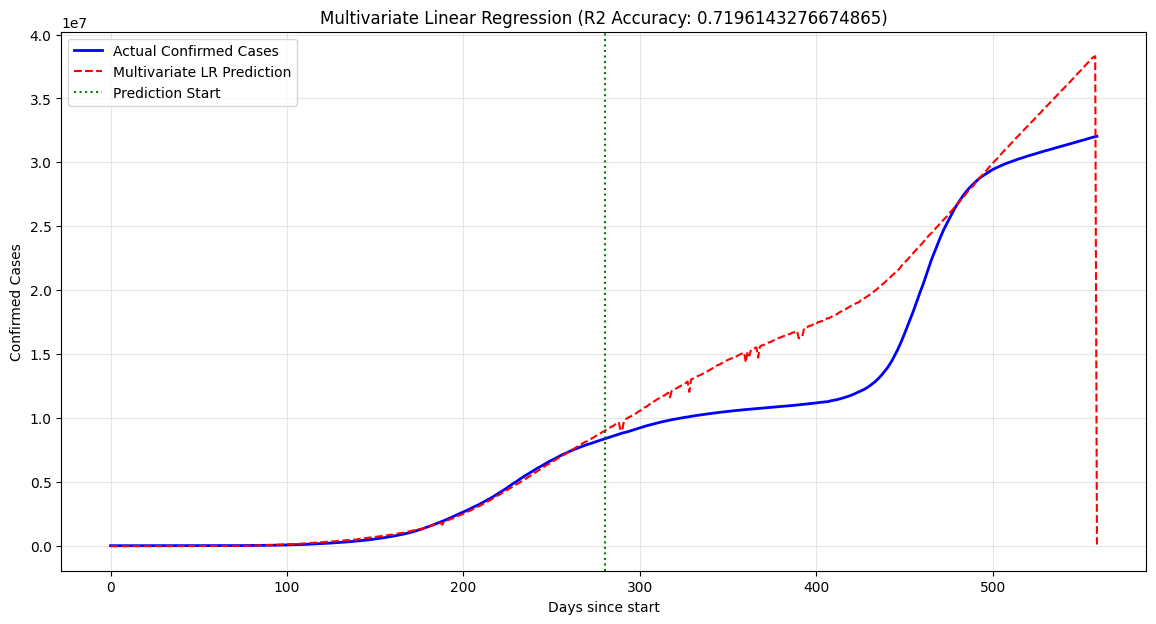

Model Equation Slope Coefficients: {'Day': np.float64(242.39745483516944), 'Total Individuals Vaccinated': np.float64(0.0), 'TotalSamples': np.float64(0.07305014687076698)}


In [9]:
# 1. Train Multivariate Model
model = LinearRegression()
model.fit(X_train, y_train)

# 2. Predict on full dataset
master_df['Predicted_Confirmed'] = model.predict(master_df[features])

# 3. Calculate Accuracy on the "Future" (Test Data)
score = r2_score(y_test, model.predict(X_test)) if not test_df.empty else "N/A"

# 4. Plotting
plt.figure(figsize=(14, 7))
plt.plot(master_df['Day'], master_df['Confirmed'], label='Actual Confirmed Cases', color='blue', linewidth=2)
plt.plot(master_df['Day'], master_df['Predicted_Confirmed'], label='Multivariate LR Prediction', color='red', linestyle='--')

# Highlight Prediction Zone
if cut_idx < n_total:
    plt.axvline(x=cut_idx, color='green', linestyle=':', label='Prediction Start')

plt.title(f'Multivariate Linear Regression (R2 Accuracy: {score})')
plt.xlabel('Days since start')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Model Equation Slope Coefficients: {dict(zip(features, model.coef_))}")